# Исследование корреляции солнечной активности и биржи

In [2]:
import pandas as pd

In [3]:
#url = 'https://www.spaceweather.gc.ca/solar_flux_data/daily_flux_values/fluxtable.txt'
df = pd.read_csv('fluxtable.txt', delim_whitespace=True, skiprows=[1])

# Объединяем fluxdate и fluxtime в одно поле timestamp
df['timestamp'] = pd.to_datetime(df['fluxdate'].astype(str) + df['fluxtime'].astype(str), format='%Y%m%d%H%M%S')

# Удаляем старые колонки fluxdate и fluxtime
df.drop(columns=['fluxdate', 'fluxtime'], inplace=True)

# Перемещаем колонку timestamp в начало
df = df[['timestamp'] + [col for col in df.columns if col != 'timestamp']]
df.head(3)

,timestamp,fluxjulian,fluxcarrington,fluxobsflux,fluxadjflux,fluxursi
0,2004-10-28 17:00:00,2453307.229,2022.605,132.7,130.9,117.8
1,2004-10-28 20:00:00,2453307.354,2022.610,135.8,134.0,120.6
2,2004-10-29 20:00:00,2453308.354,2022.646,130.6,128.8,115.9


In [4]:
solar=df.set_index('timestamp')[['fluxadjflux']].resample('D').mean().reset_index()
solar.head(3)

,timestamp,fluxadjflux
0,2004-10-28,132.450000
1,2004-10-29,130.550000
2,2004-10-30,139.466667


In [5]:
import yfinance as yf

In [6]:
tickers = '''AAPL, MSFT, AMZN, GOOGL, META, TSLA, JNJ, JPM, V, PG, NVDA, WMT, 
             DIS, BAC, MA, INTC, PFE, XOM, NFLX, ADBE, CRM, KO, PEP, GE'''

# Загружаем данные с конкретной начальной даты
raw_data = yf.download(
    tickers=tickers,
    start="2004-10-28",
    interval="1d",
    progress=False,
    group_by='ticker',
    threads=True  # Параллельная загрузка для ускорения
)

YF.download() has changed argument auto_adjust default to True


In [7]:
raw_data.head(3)

Ticker            JPM                                                   BAC   
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2004-10-28  21.970507  22.376831  21.866023  22.336199   8766200  27.908229  \
2004-10-29  22.301366  22.417459  22.069182  22.405849  11215900  28.243644   
2004-11-01  22.504532  22.603210  22.307175  22.347807  10154500  28.427181   

Ticker                                                   ...       INTC   
Price            High        Low      Close      Volume  ...       Open   
Date                                                     ...              
2004-10-28  28.332233  27.908229  28.174023   7280000.0  ...  12.665089  \
2004-10-29  28.414511  28.199345  28.344898  10054500.0  ...  12.884345   
2004-11-01  28.591721  28.363898  28.547422   8223900.0  ...  12.803567   

Ticker                                                     NFLX             
Price            High        Low      Close    Volume      Open      High   
Date                                                                        
2004-10-28  13.045907  12.659319  12.849728  66702100  1.407143  1.408571  \
2004-10-29  12.982434  12.792025  12.843955  62332400  1.364286  1.385714   
2004-11-01  12.976665  12.780486  12.947816  49790900  1.354286  1.371429   

Ticker                                    
Price            Low     Close    Volume  
Date                                      
2004-10-28  1.357143  1.370000  10278100  
2004-10-29  1.342857  1.352857  15493100  
2004-11-01  1.335714  1.347143  13169100  

[3 rows x 120 columns]

In [8]:
# Извлекаем цены закрытия и преобразуем структуру
close_prices = (
    raw_data
    .xs('Close', level=1, axis=1)      # Выбираем уровень Close
    .sort_index()                       # Сортируем по времени
)
close_prices.head(3)

Ticker,JPM,BAC,KO,GE,XOM,AMZN,CRM,PG,JNJ,AAPL,...,NVDA,GOOGL,V,PFE,MSFT,META,MA,PEP,INTC,NFLX
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-28,22.336199,28.174023,10.985543,97.819008,24.671719,1.7225,5.009520,29.297026,32.668507,0.785292,...,0.112572,4.819864,NaN,11.836777,17.440020,NaN,NaN,28.334286,12.849728,1.370000
2004-10-29,22.405849,28.344898,11.031663,98.077766,24.981314,1.7065,5.051784,29.222811,32.876865,0.788452,...,0.110585,4.753539,NaN,11.935730,17.415110,NaN,NaN,28.357168,12.843955,1.352857
2004-11-01,22.347807,28.547422,10.996400,97.876534,24.778297,1.7550,5.394868,29.120022,32.910675,0.789204,...,0.112955,4.887937,NaN,11.873890,17.483606,NaN,NaN,28.197023,12.947816,1.347143


In [9]:
# Для солнечных данных
solar = df.set_index('timestamp')[['fluxadjflux']].resample('D').mean()

# Для цен акций (ваш текущий код)
close_prices = raw_data.xs('Close', level=1, axis=1).sort_index()

# Объединяем данные в один DataFrame
combined = solar.join(close_prices, how='inner').dropna()


combined.head(5)

,fluxadjflux,JPM,BAC,KO,GE,XOM,AMZN,CRM,PG,JNJ,...,NVDA,GOOGL,V,PFE,MSFT,META,MA,PEP,INTC,NFLX
2012-05-18,134.033333,23.570286,5.621061,24.911932,70.976334,48.813293,10.6925,36.192844,44.061718,44.162277,...,0.276960,14.970756,25.710611,13.038117,23.397005,38.084518,36.651817,47.047935,18.292824,9.994286
2012-05-21,128.333333,22.880554,5.468924,25.066687,71.613083,49.154819,10.9055,37.055531,43.971558,44.245926,...,0.281774,15.312610,26.527769,13.020788,23.780691,33.900501,38.139965,46.951260,18.348951,10.248571
2012-05-22,123.900000,23.936256,5.589030,24.959030,71.837784,49.100887,10.7665,37.154976,43.805069,44.280781,...,0.278335,14.980729,27.023079,12.922584,23.788691,30.882032,38.405647,47.020332,18.264755,9.672857
2012-05-23,119.966667,24.112209,5.741167,25.080143,71.837784,49.154819,10.8640,37.443363,43.277874,44.106503,...,0.285213,15.196662,27.201117,12.760830,23.269112,31.878227,38.744701,46.965076,17.850760,10.272857
2012-05-24,119.766667,23.908104,5.717145,25.419926,72.099983,49.496338,10.7620,36.349476,43.402744,44.416214,...,0.277648,15.052042,27.338074,12.789719,23.237135,32.904308,38.999233,47.524513,17.998108,10.038571


In [14]:
# Рассчитываем корреляции с статистической значимостью
from scipy.stats import pearsonr
ticker_columns = [col for col in combined.columns if col != 'fluxadjflux']

corr_list = []
for ticker in ticker_columns:
    r, p_value = pearsonr(combined['fluxadjflux'], combined[ticker])
    corr_list.append({
        'Ticker': ticker,
        'Correlation': r,
        'p-value': p_value,
        'Significant (5%)': p_value < 0.05
    })

corr_df = pd.DataFrame(corr_list).sort_values('Correlation', key=abs, ascending=False)

print("Детализированные результаты корреляции:")
print(corr_df)

Детализированные результаты корреляции:
   Ticker  Correlation        p-value  Significant (5%)
4     XOM     0.703125   0.000000e+00              True
14   NVDA     0.595199  1.881384e-306              True
3      GE     0.480626  6.820874e-185              True
22   INTC    -0.466321  9.739801e-173              True
9    AAPL     0.450733  3.889772e-160              True
13    WMT     0.438294  1.531904e-150              True
18   MSFT     0.415934  2.851850e-134              True
15  GOOGL     0.371646  1.691134e-105              True
2      KO     0.368140  2.094477e-103              True
11    DIS    -0.363325  1.425644e-100              True
7      PG     0.360829   4.010094e-99              True
12   TSLA     0.356313   1.559911e-96              True
0     JPM     0.341031   4.446076e-88              True
19   META     0.308040   2.183027e-71              True
21    PEP     0.302414   9.564263e-69              True
20     MA     0.288541   1.764263e-62              True
16      

# Проверка

Если эффект есть, значит он должен быть устойчивым.
Просто разделим данные на два промежутка. Выберем дату произвольно

In [15]:
# Разделяем данные на две части по дате
split_date = '2019-01-01'

combined_before = combined.loc[:split_date]  # Все данные ДО 2019-01-01
combined_after = combined.loc[split_date:]   # Все данные ПОСЛЕ 2019-01-01 (включительно)

In [16]:
combined_before.head(3)

,fluxadjflux,JPM,BAC,KO,GE,XOM,AMZN,CRM,PG,JNJ,...,NVDA,GOOGL,V,PFE,MSFT,META,MA,PEP,INTC,NFLX
2012-05-18,134.033333,23.570286,5.621061,24.911932,70.976334,48.813293,10.6925,36.192844,44.061718,44.162277,...,0.276960,14.970756,25.710611,13.038117,23.397005,38.084518,36.651817,47.047935,18.292824,9.994286
2012-05-21,128.333333,22.880554,5.468924,25.066687,71.613083,49.154819,10.9055,37.055531,43.971558,44.245926,...,0.281774,15.312610,26.527769,13.020788,23.780691,33.900501,38.139965,46.951260,18.348951,10.248571
2012-05-22,123.900000,23.936256,5.589030,24.959030,71.837784,49.100887,10.7665,37.154976,43.805069,44.280781,...,0.278335,14.980729,27.023079,12.922584,23.788691,30.882032,38.405647,47.020332,18.264755,9.672857


In [17]:
combined_after.head(3)

,fluxadjflux,JPM,BAC,KO,GE,XOM,AMZN,CRM,PG,JNJ,...,NVDA,GOOGL,V,PFE,MSFT,META,MA,PEP,INTC,NFLX
2019-01-02,72.400000,82.916222,21.551338,38.957546,37.585014,51.719872,76.956497,134.797089,77.998955,108.155220,...,3.378090,52.543530,127.274940,31.420740,95.310524,135.163666,183.216736,91.920593,40.518051,267.660004
2019-01-03,70.533333,81.737862,21.205957,38.716805,37.631702,50.925774,75.014000,129.675705,77.452072,106.436577,...,3.173996,51.088303,122.688332,30.541676,91.804253,131.238678,174.951035,91.062630,38.289043,271.200012
2019-01-04,69.566667,84.751144,22.086664,39.488823,38.425438,52.803387,78.769501,137.193726,79.032913,108.222939,...,3.377346,53.708797,127.973946,31.239111,96.074005,137.425049,183.235977,92.929955,40.638531,297.570007


In [18]:

# Создаем функцию для расчета корреляций
def calculate_correlations(df):
    corr_list = []
    for ticker in df.columns.drop('fluxadjflux'):
        r, p_value = pearsonr(df['fluxadjflux'], df[ticker])
        corr_list.append({
            'Ticker': ticker,
            'Correlation': r,
            'p-value': p_value,
            'Significant (5%)': p_value < 0.05
        })
    return pd.DataFrame(corr_list).sort_values('Correlation', key=abs, ascending=False)

# Считаем для первого периода
print("Корреляции ДО 2019-01-01:")
corr_before = calculate_correlations(combined_before)
print(corr_before)

# Считаем для второго периода
print("\nКорреляции ПОСЛЕ 2019-01-01:")
corr_after = calculate_correlations(combined_after)
print(corr_after)

Корреляции ДО 2019-01-01:
   Ticker  Correlation        p-value  Significant (5%)
5    AMZN    -0.708256  1.286142e-253              True
15  GOOGL    -0.704263  1.490076e-249              True
19   META    -0.693574  5.283444e-239              True
0     JPM    -0.690082  1.175218e-235              True
16      V    -0.688774  2.046721e-234              True
18   MSFT    -0.687889  1.405180e-233              True
14   NVDA    -0.687399  4.062655e-233              True
21    PEP    -0.678201  1.282307e-224              True
2      KO    -0.671477  1.340298e-218              True
10   ADBE    -0.667547  3.727956e-215              True
8     JNJ    -0.660193  7.536832e-209              True
23   NFLX    -0.654410  5.151881e-204              True
6     CRM    -0.649794  3.127265e-200              True
20     MA    -0.644770  3.457595e-196              True
9    AAPL    -0.637069  3.892752e-190              True
22   INTC    -0.630538  3.880570e-185              True
1     BAC    -0.615966

Эффект не повторился.


# Графики
все же попробуем графически понять почему некоторые тикеры  хорошо коррелируют

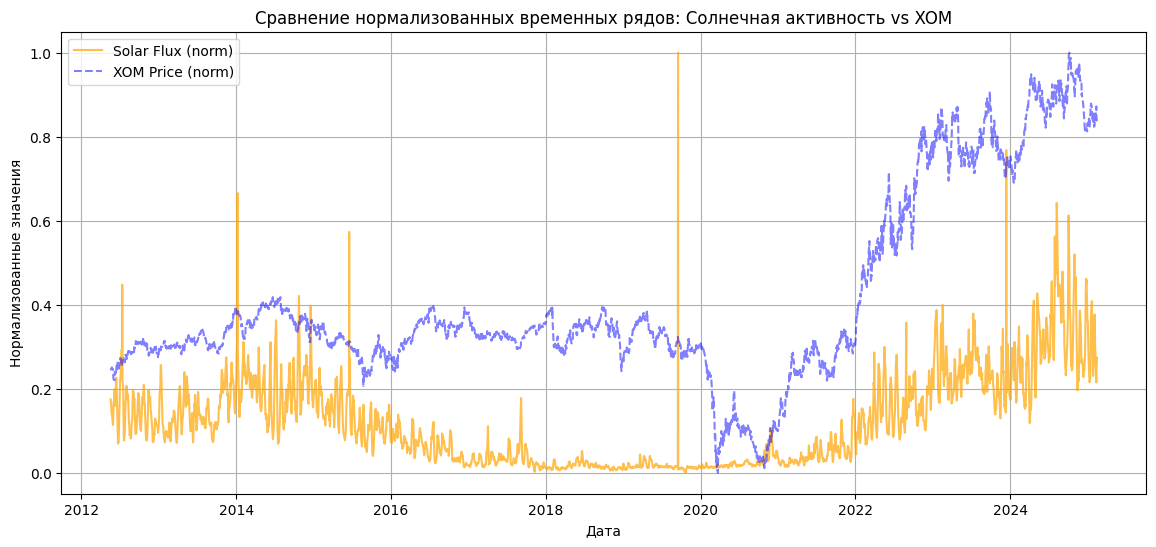

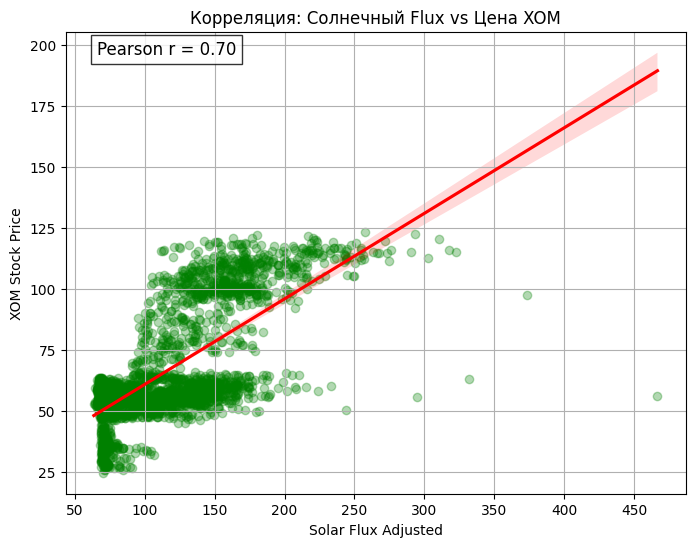

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Проверяем наличие XOM
if 'XOM' not in combined.columns:
    raise ValueError("Тикер XOM отсутствует в данных")

# Нормализация вручную
def manual_minmax_scale(series):
    return (series - series.min()) / (series.max() - series.min())

normalized_data = pd.DataFrame({
    'fluxadjflux_norm': manual_minmax_scale(combined['fluxadjflux']),
    'XOM_norm': manual_minmax_scale(combined['XOM'])
}, index=combined.index)

# График временных рядов (остается без изменений)
plt.figure(figsize=(14, 6))
plt.title('Сравнение нормализованных временных рядов: Солнечная активность vs XOM')

plt.plot(normalized_data['fluxadjflux_norm'], 
         label='Solar Flux (norm)', 
         color='orange',
         alpha=0.7)

plt.plot(normalized_data['XOM_norm'], 
         label='XOM Price (norm)', 
         color='blue',
         alpha=0.5,
         linestyle='--')

plt.legend()
plt.xlabel('Дата')
plt.ylabel('Нормализованные значения')
plt.grid(True)
plt.show()

# Scatter plot с регрессией (seaborn использует scipy, должен работать)
plt.figure(figsize=(8, 6))
sns.regplot(x=combined['fluxadjflux'], 
            y=combined['XOM'],
            scatter_kws={'alpha':0.3, 'color':'green'},
            line_kws={'color':'red'})

plt.title('Корреляция: Солнечный Flux vs Цена XOM')
plt.xlabel('Solar Flux Adjusted')
plt.ylabel('XOM Stock Price')
plt.grid(True)

# Коэффициент корреляции через pandas
r = combined['fluxadjflux'].corr(combined['XOM'])
plt.annotate(f'Pearson r = {r:.2f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

plt.show()